## Question 4: Image processing for human faces
<p> In this problem, we will process face images coming from the Yale Face Dataset: http:
//vision.ucsd.edu/content/yale-face-database. This dataset contains images of the faces
of 15 individuals. For each individual there are 11 images taken under a variety of conditions
e.g., the person makes a happy expression, wears glasses etc.</p>

(a) Download the dataset from the above URL. Implement Principal Component Analysis
(PCA) on the input images. Assume that the input vector of PCA contains all rows of an
image stacked one on top of the other. You can use available libraries that calculate eigenvalues
and eigenvectors of a matrix. Hint: Don’t forget to normalize the data.


In [27]:
import os, os.path
import pandas as pd
from glob import iglob
#import cv2
import numpy as np
from skimage import io
import warnings
warnings.filterwarnings("ignore")
#import xgboost as xgb

imgs = pd.DataFrame([])
path = "yalefaces"

image_labels = []

images_path = [ os.path.join("yalefaces", item)  for item in  os.listdir(path) ]
images_path.sort()
subject_list = [item for item in os.listdir(path)]
subject_list.sort()

for i,final_path in enumerate(images_path):
    im = io.imread(final_path,as_grey=True)
    face = pd.Series(im.flatten(),name=final_path)    
    imgs=imgs.append(face)
    label = int(os.path.split(final_path)[1].split(".")[0].replace("subject", ""))  -1
    image_labels.append(label)

In [28]:
from sklearn.decomposition import PCA 
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
    
# normalizing
scaler = StandardScaler()
normalized_images= scaler.fit_transform(imgs)
normalized_images= pd.DataFrame(normalized_images)

(b) Plot a curve displaying the first k eigenvalues λ1, . . . , λK, i.e. the energy of the first K
principal components. How many components do we need to capture 50% of the energy?

Top  10   eignevalues 
 [21295.87303699 13209.03643153  7112.99676748  5346.93891589
  2909.26655669  2541.20080242  2216.37342542  1854.15605947
  1647.44678955  1312.97731327]


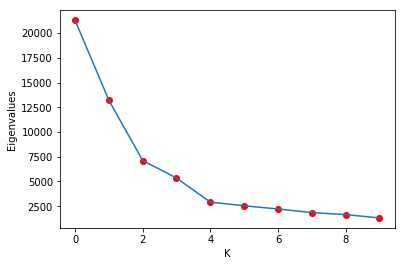

In [29]:
k = 10
pca1 = PCA(n_components=k)

pca1.fit_transform(normalized_images)

print("Top ",k,"  eignevalues \n",pca1.explained_variance_)
plt.plot(np.arange(k),pca1.explained_variance_,'ro')
plt.plot(np.arange(k),pca1.explained_variance_)
plt.ylabel("Eigenvalues")
plt.xlabel("K")
plt.show()

For 50% energy we wolud need 3 components and they are displayed below and thier corresponding eigen vectors are also shown

In [30]:
pca2 = PCA(0.5)

pca2.fit_transform(normalized_images)

print("No of components = ",len(pca2.explained_variance_))

No of components =  3


(c) Plot the top 10 eigenfaces, i.e. the eigenvectors uk, k = 1, . . . , 10 obtained by PCA.

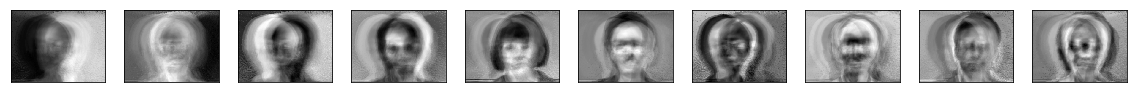

In [31]:
pca3 = PCA(n_components=10)

pca3.fit_transform(normalized_images)

fig, axes3 = plt.subplots(1,10,figsize=(20,2))
plt.setp(axes3, xticks=[],yticks=[])

for i, ax in enumerate(axes3.flat):
    ax.imshow(pca3.components_[i].reshape(243,320),cmap="gray")

(d) Select a couple of images from the data. Use the first k eigenfaces as a basis to reconstruct
the images. Visualize the reconstructed images using 1, 10, 20, 30, 40, 50 components. How
many components do we need to achieve a visually good result?
Hint: Reconstruction of an input vector x based on the eigenvectors u1, . . . , uK is given by the
following expression x ≈ x0 +
PK
k=1 ckuk, where ck = u
T
k
x is the projection of the input image
to the k
th eigenvector.


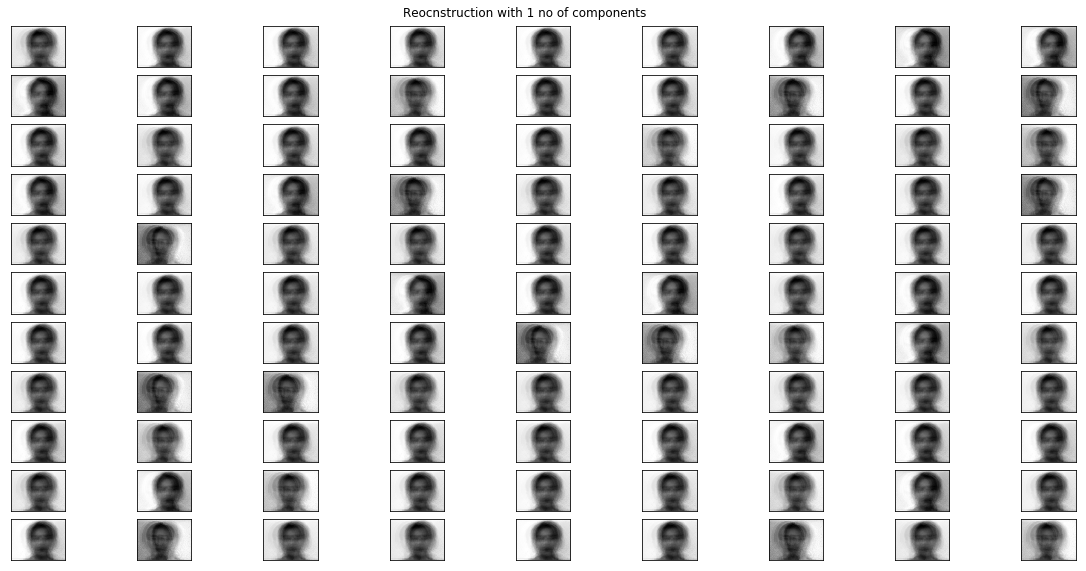

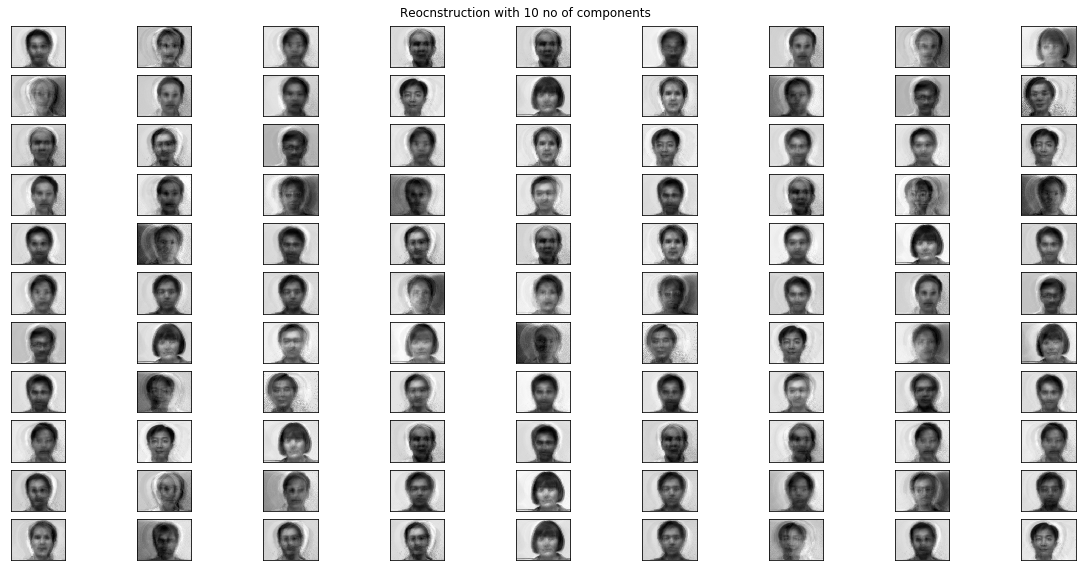

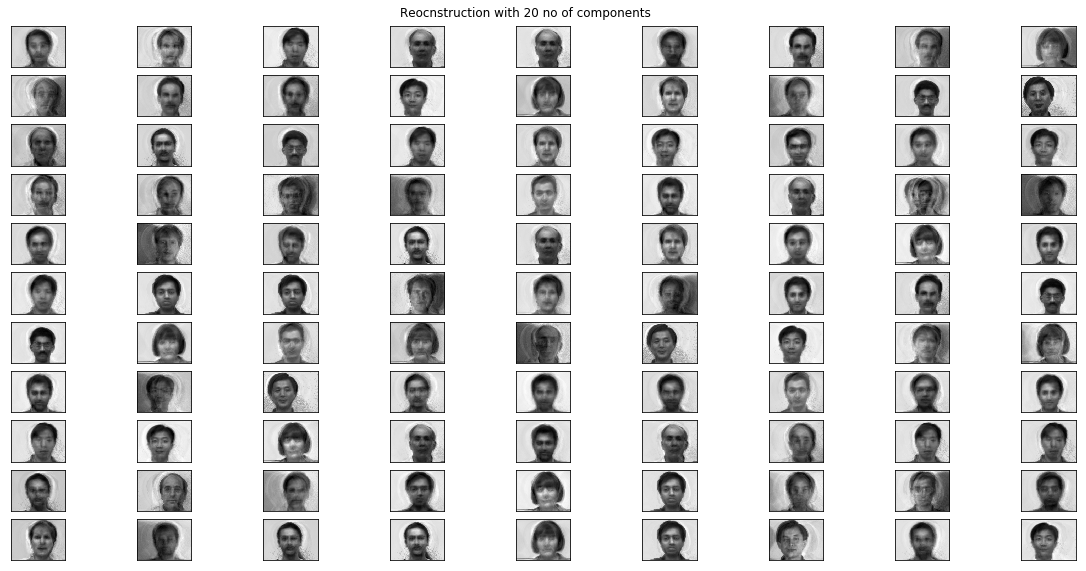

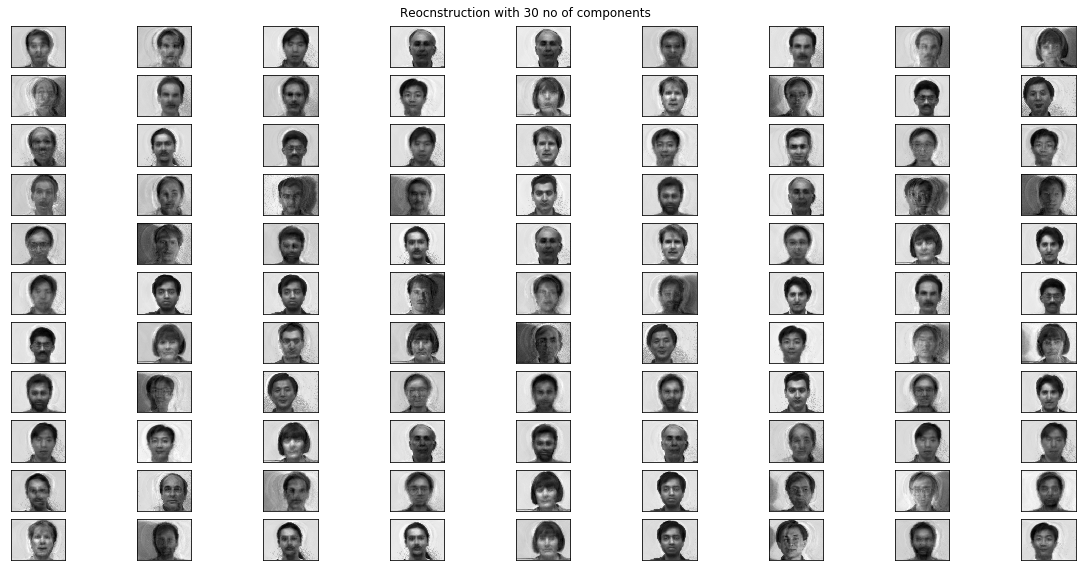

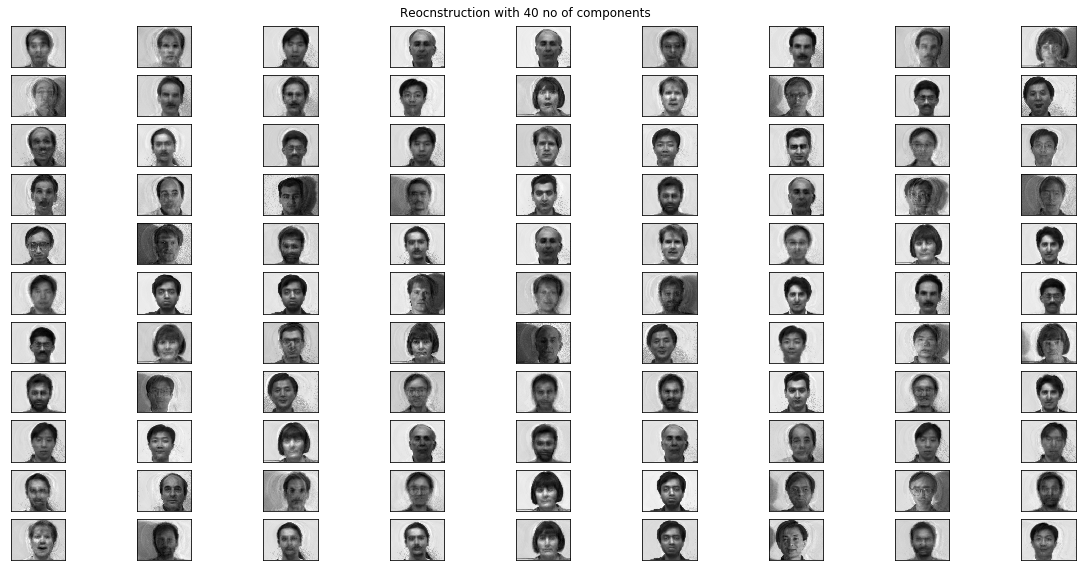

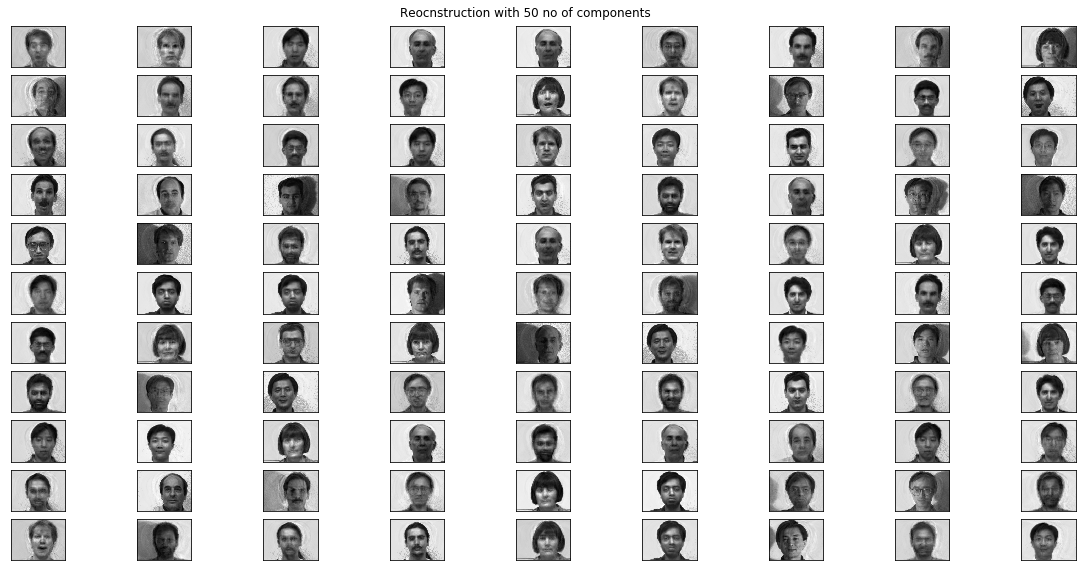

In [32]:
import cv2

sample = imgs.sample(n=int(166*0.6))

x = scaler.fit_transform(sample)
components_list = [1,10,20,30,40,50]

for j in components_list:
    pca_normalized = PCA(n_components=j)
    pca_normalized.fit_transform(normalized_images)

    components = pca_normalized.transform(x)
    projected = pca_normalized.inverse_transform(components)
    projected = scaler.inverse_transform(projected)

    fig, axes5 = plt.subplots(11,9,figsize=(20,9))
    plt.setp(axes5, xticks=[],yticks=[])

    for i, ax in enumerate(axes5.flat):
        a = np.asarray(projected[i]).reshape(243,320)
        fig.subplots_adjust(top=0.95)
        fig.suptitle("Reocnstruction with "+ str(j)+ " no of components")
        ax.imshow(a,cmap="gray")    


We can see that we can distinguish faces with 40 components but higher the number of componnets better would be the result as it would explain more variance.

(e) Perform face recognition: Split the input data into training and testing making sure that
every person is included in each set. Use as input features the transformed feature space that
resulted from PCA. Experiment with different number of PCA components through a 5-fold
cross-validation. User an outer 5-fold cross-validation to build predictors using a boosting
method (e.g. adaboost, xgboost), support vector machines (report kernel you used), and CNNs
2
(experiment with filter size, stride size, activation function, drop out). Report the recognition
accuracy on the test set.

In [33]:
#Splitting training and testing data keeping testing data as 20%
from sklearn.model_selection import train_test_split
label_df = pd.DataFrame(image_labels)
X_train, X_test, Y_train, Y_test = train_test_split(imgs, label_df, test_size=0.2, random_state=40,stratify=label_df)

In [34]:
a = np.asarray(Y_train)
unique, counts = np.unique(Y_train, return_counts=True)

print(np.asarray((unique, counts)))

[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
 [ 9  9  8  8  9  9  9  8  9  9  9  9  9  9  9]]


In [37]:
from sklearn.model_selection import StratifiedKFold
from numpy import linalg as LA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

splits = 5

skf = StratifiedKFold(n_splits=splits,random_state=0)

In [ ]:
train_score_dict ={'rf':0,'svm':0,'XGB':0}
test_score_dict ={'rf':0,'svm':0,'XGB':0}

for train_index, test_index in skf.split(X_train,Y_train):
    x_train, x_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train, y_test = Y_train.iloc[train_index], Y_train.iloc[test_index]
    
    train_error = []
    test_error = []
    print("*")
    components = [65,67,68,69,72]
    
    for i in components:

        temp_train_error = 0
        temp_test_error = 0
        for train_index, test_index in skf.split(x_train,y_train):
    
            xx_train, xx_test = x_train.iloc[train_index], x_train.iloc[test_index]
            yy_train, yy_test = y_train.iloc[train_index].values.ravel(), y_train.iloc[test_index].values.ravel()

            scaler_1 = StandardScaler()
            scaler_1.fit(xx_train)
            xx_train=scaler_1.transform(xx_train)
            xx_test = scaler_1.transform(xx_test)
            ds = scaler_1.transform(x_test)

            pca5 = PCA(n_components=i)

            train_transform=pca5.fit_transform(xx_train)
            
            test_transform = pca5.transform(xx_test)
            outer_test_transform = pca5.transform(ds)

            test_projected = pca5.inverse_transform(test_transform)
            outer_test_projected = pca5.inverse_transform(outer_test_transform)

            temp_train_error+=(LA.norm((xx_test-test_projected),None)/splits)        
            temp_test_error+=(LA.norm((x_test-outer_test_projected),None)/splits)
            
        train_error.append(temp_train_error)
        test_error.append(temp_test_error)

    #Scaling Images
    scaler_2 = StandardScaler().fit(x_train)
    x_train_norm = pd.DataFrame(scaler_2.transform(x_train))
    x_test_norm = pd.DataFrame(scaler_2.transform(x_test))
    X_outter_test = pd.DataFrame(scaler_2.transform(X_test))


    # Training with Final PCA
    index = np.argmin(test_error)
    final_components=components[index]
    print(final_components)
    final_pca = PCA(n_components=final_components)

    train_input_features = final_pca.fit_transform(x_train_norm)
    test_input_features = final_pca.transform(x_test_norm)
    final_test_input_features = final_pca.transform(X_outter_test)
    
    # Random Forest
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(train_input_features, y_train.values.ravel())
    
    train_pred = rf.predict(test_input_features)
    test_pred = rf.predict(final_test_input_features)
    
    temp_train_score = f1_score(np.asarray(y_test),np.array(train_pred),average="weighted")
    temp_test_score = f1_score(np.asarray(Y_test),np.array(test_pred),average="weighted")
    
    train_score_dict['rf'] += f1_score(np.asarray(y_test),np.array(train_pred),average="weighted")/splits
    test_score_dict['rf'] += f1_score(np.asarray(Y_test),np.array(test_pred),average="weighted")/splits
        
    #SVM
    svm = SVC(kernel="linear")
    svm.fit(train_input_features, y_train.values.ravel())
    
    train_pred = svm.predict(test_input_features)
    test_pred = svm.predict(final_test_input_features)
    
    temp_train_score = f1_score(np.array(y_test),np.array(train_pred),average="weighted")
    temp_test_score = f1_score(np.array(Y_test),np.array(test_pred),average="weighted")
    
    train_score_dict['svm'] += f1_score(np.array(y_test),np.array(train_pred),average="weighted") / splits
    test_score_dict['svm'] += f1_score(np.array(Y_test),np.array(test_pred),average="weighted") / splits
        
    #XGBosst
    xgb_c = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=-1)
    xgb_c.fit(train_input_features, y_train.values.ravel())
    
    train_pred = xgb_c.predict(test_input_features)
    test_pred = xgb_c.predict(final_test_input_features)
    
    train_score_dict['XGB'] += f1_score(np.array(y_test),np.array(train_pred),average="weighted") / splits
    test_score_dict['XGB'] += f1_score(np.array(Y_test),np.array(test_pred),average="weighted") / splits
    
    
print("Comparing All F1 Scores")   
print("Random Forest F1 Score",test_score_dict['rf'])
print("SVM F1 Score",test_score_dict['svm'])
print("XGBoost F1 Score",test_score_dict['XGB'])

In [ ]:
IMG_SIZE =243
LR = 1e-3
data = []

for i,final_path in enumerate(images_path):
    im = io.imread(final_path,as_grey=True)
    im = cv2.resize(im, (IMG_SIZE,IMG_SIZE))
    data.append(np.array(im))

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

data = np.asarray(data)

print(np.asarray(data).shape)
X_train, X_test, Y_train, Y_test = train_test_split(data, image_labels, test_size=0.2, random_state=40,stratify=image_labels)

# print(Y_train)
a = np.asarray(Y_train)
unique, counts = np.unique(Y_train, return_counts=True)

print(np.asarray((unique, counts)))

In [ ]:
#CNN
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

import tensorflow as tf
tf.reset_default_graph()

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet,32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 15, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=40,stratify=Y_train)

x = np.array([i for i in x_train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
t_x = np.array([i for i in x_test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)

train_encoded_labels = to_categorical(y_train,15)
test_encoded_labels = to_categorical(y_test,15)

train_encoded_labels=train_encoded_labels.astype(np.uint8)
test_encoded_labels=test_encoded_labels.astype(np.uint8)

In [ ]:
model.fit({'input': x}, {'targets': train_encoded_labels}, n_epoch=20, validation_set=({'input': t_x}, {'targets': test_encoded_labels}), 
    snapshot_step=500, show_metric=True,run_id="a")

In [ ]:
x_t = np.array([i for i in X_test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
main_test_encoded = to_categorical(Y_test,15)
main_test_encoded=main_test_encoded.astype(np.uint8)

score = model.evaluate(x_t, main_test_encoded)
print('Test Accuracy:', score[0])

(f) Perform type recognition with Gaussian Mixture Models: Setting the number of components
to be equal to the number of poses each subject can have, and using the data obtained by PCA,
see if a Gaussian Mixture Model, trained with Expectation Maximization, naturally clusters
the pictures by pose type.

In [ ]:
from sklearn.mixture import GaussianMixture

sklearn_pca = PCA(0.9)

#Scaling
scaler_4 = StandardScaler().fit(imgs)
x_train_norm = pd.DataFrame(scaler_4.transform(imgs))

#Applying PCA
Y_sklearn = sklearn_pca.fit_transform(x_train_norm)

#Applying GMM
gmm = GaussianMixture(n_components=11)
prediction_gmm = gmm.fit_predict(Y_sklearn)

In [ ]:
for i in range(len(image_labels)):
    if i%11==0:
        print("\n")
#     if subject_list[i].split('.')[1]=="sad":
    print(subject_list[i]," Cluster :",prediction_gmm[i])

As we can see the clusters are naturally coming around the subject faces and the face type of subjects. Thus GMM is not naturally clustering images to face type.